In [1]:
import time

import pathlib

import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array,  load_img

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import MobileNetV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


from IPython.display import display, Markdown

## Pengaturan Hyperparameter dan Konfigurasi Model

In [2]:
INIT_LR = 1e-4
EPOCHS = 40
BS = 1
SIZE_X = 112
SIZE_Y = 112
IMG_CHANNELS = 3

NETWORK = "SPEoR_Tesis_Bismillah_ResNet50V2.1"

image_dataset = r"C:\Users\Lab129\Downloads\Indi\HasilSeg"
brats_id_offset = 2
image_dataset_pattern = "*/*"
sp_dataset = r"C:\Users\Lab129\Downloads\Indi\survival_info_final.csv"
grade_dataset = r"C:\Users\Lab129\Downloads\Indi\cla_112_mv_weighted31.csv"
model_path = NETWORK + "_" + str(EPOCHS) + ".model"

## Pre-processing Data

### Loading Dataframe

In [3]:
pathimage = pathlib.Path(image_dataset)

print("[INFO] loading dataframe...")
df = pd.read_csv(sp_dataset)
cla_df = pd.read_csv(grade_dataset)

# Set datatypes
df["Brats20ID"] = df["Brats20ID"].astype('string')
df["Survival_categories"] = df["Survival_categories"].astype('category')
df["Extent_of_Resection"] = df["Extent_of_Resection"].astype('category')
cla_df["Grade"] = cla_df["Grade"].astype('category')

# Put grade in cla_df into df by Brats20ID
df = pd.merge(df, cla_df, left_on='Brats20ID', right_on='BraTS_2020_subject_ID')
df.drop(columns=['BraTS_2020_subject_ID'], inplace=True)

df.info()
display(df.head(), df["Survival_categories"].value_counts(), df["Extent_of_Resection"].value_counts())

[INFO] loading dataframe...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 0 to 368
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Brats20ID            369 non-null    object  
 1   Age                  369 non-null    float64 
 2   Survival_categories  369 non-null    category
 3   Extent_of_Resection  217 non-null    category
 4   Grade                369 non-null    category
dtypes: category(3), float64(1), object(1)
memory usage: 10.1+ KB


,Brats20ID,Age,Survival_categories,Extent_of_Resection,Grade
0,BraTS20_Training_001,60.463,Mid-survivors,GTR,HGG
1,BraTS20_Training_002,52.263,Long-survivors,GTR,HGG
2,BraTS20_Training_003,54.301,Mid-survivors,GTR,HGG
3,BraTS20_Training_004,39.068,Long-survivors,GTR,HGG
4,BraTS20_Training_005,68.493,Mid-survivors,GTR,HGG


Long-survivors     196
Mid-survivors       96
Short-survivors     77
Name: Survival_categories, dtype: int64

GTR    165
STR     52
Name: Extent_of_Resection, dtype: int64

In [4]:
df["Survival_categories"].cat.categories, np.unique(df["Survival_categories"].cat.codes)

(Index(['Long-survivors', 'Mid-survivors', 'Short-survivors'], dtype='object'),
 array([0, 1, 2], dtype=int8))

In [5]:
# df_show = df.copy()
# df_show["label_code"] = df_show["Survival_categories"].cat.codes
# display(df_show.groupby("Survival_categories", group_keys=True).apply(lambda x: x.sample(3)))
# del df_show

### Class Imbalance

In [6]:
# Check for class imbalance
class_count = df["Survival_categories"].value_counts()
display(class_count)

Long-survivors     196
Mid-survivors       96
Short-survivors     77
Name: Survival_categories, dtype: int64

####  Oversampling Class (SMOTE)

In [7]:
sm = SMOTE(random_state=42)

# Resample the dataset by index
X_res, _ = sm.fit_resample(df.index.values.reshape(-1, 1), df["Survival_categories"].cat.codes.values)

# Create a new dataframe
df_res = df.iloc[X_res.flatten()].copy()

df_res.info()
display(df_res.head(), df_res["Survival_categories"].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 588 entries, 0 to 178
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Brats20ID            588 non-null    object  
 1   Age                  588 non-null    float64 
 2   Survival_categories  588 non-null    category
 3   Extent_of_Resection  331 non-null    category
 4   Grade                588 non-null    category
dtypes: category(3), float64(1), object(1)
memory usage: 15.9+ KB


,Brats20ID,Age,Survival_categories,Extent_of_Resection,Grade
0,BraTS20_Training_001,60.463,Mid-survivors,GTR,HGG
1,BraTS20_Training_002,52.263,Long-survivors,GTR,HGG
2,BraTS20_Training_003,54.301,Mid-survivors,GTR,HGG
3,BraTS20_Training_004,39.068,Long-survivors,GTR,HGG
4,BraTS20_Training_005,68.493,Mid-survivors,GTR,HGG


Long-survivors     246
Short-survivors    172
Mid-survivors      170
Name: Survival_categories, dtype: int64

### One Hot Encoding Label

In [8]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(df_res["Survival_categories"])
label_one_hot_encoded = to_categorical(label_encoded)

### Encoding Grade

In [17]:
df["Grade"].cat.categories, df["Grade"].cat.codes.unique()

(Index(['HGG', 'LGG'], dtype='object'), array([0, 1], dtype=int8))

In [18]:
grade_encoder = LabelEncoder()
grade_encoded = grade_encoder.fit_transform(df_res["Grade"])
df_res["grade_code"] = grade_encoded

C:\Users\Lab129\AppData\Local\Temp\ipykernel_18400\3392921298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res["grade_code"] = grade_encoded


### Encoding Extent of Resection

In [11]:
df["Extent_of_Resection"].cat.categories, df["Extent_of_Resection"].cat.codes.unique()

(Index(['GTR', 'STR'], dtype='object'), array([ 0, -1,  1], dtype=int8))

In [12]:
df_res = df.iloc[X_res.flatten()]
extent_encoder = LabelEncoder()
extent_encoded = extent_encoder.fit_transform(df_res["Extent_of_Resection"])
df_res["eor_code"] = extent_encoded

C:\Users\Lab129\AppData\Local\Temp\ipykernel_18400\1560814556.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res["eor_code"] = extent_encoded


### Loading Images

In [13]:
print("[INFO] loading images...")
# List all the files in the directory
pathimage = pathlib.Path(image_dataset)

df_img = pd.DataFrame(columns=["Brats20ID", "image"])

imgIter = pathimage.glob(image_dataset_pattern)

df_img["image"] = [str(x) for x in imgIter]
df_img["Brats20ID"] = df_img["image"].apply(lambda x: x.split("\\")[-brats_id_offset])

df_img["Brats20ID"] = df_img["Brats20ID"].astype('string')
df_img["image"] = df_img["image"].astype('string')
df_img.info()
display(df_img.head())

df_res["images"] = df_res["Brats20ID"].map(df_img.groupby("Brats20ID")["image"].apply(list))
display(df_res.head())

[INFO] loading images...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47232 entries, 0 to 47231
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Brats20ID  47232 non-null  string
 1   image      47232 non-null  string
dtypes: string(2)
memory usage: 738.1 KB


,Brats20ID,image
0,BraTS20_Training_001,C:\Users\Lab129\Downloads\Indi\HasilSeg\BraTS2...
1,BraTS20_Training_001,C:\Users\Lab129\Downloads\Indi\HasilSeg\BraTS2...
2,BraTS20_Training_001,C:\Users\Lab129\Downloads\Indi\HasilSeg\BraTS2...
3,BraTS20_Training_001,C:\Users\Lab129\Downloads\Indi\HasilSeg\BraTS2...
4,BraTS20_Training_001,C:\Users\Lab129\Downloads\Indi\HasilSeg\BraTS2...


C:\Users\Lab129\AppData\Local\Temp\ipykernel_18400\2001165535.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res["images"] = df_res["Brats20ID"].map(df_img.groupby("Brats20ID")["image"].apply(list))


,Brats20ID,Age,Survival_categories,Extent_of_Resection,Grade,eor_code,images
0,BraTS20_Training_001,60.463,Mid-survivors,GTR,HGG,0,[C:\Users\Lab129\Downloads\Indi\HasilSeg\BraTS...
1,BraTS20_Training_002,52.263,Long-survivors,GTR,HGG,0,[C:\Users\Lab129\Downloads\Indi\HasilSeg\BraTS...
2,BraTS20_Training_003,54.301,Mid-survivors,GTR,HGG,0,[C:\Users\Lab129\Downloads\Indi\HasilSeg\BraTS...
3,BraTS20_Training_004,39.068,Long-survivors,GTR,HGG,0,[C:\Users\Lab129\Downloads\Indi\HasilSeg\BraTS...
4,BraTS20_Training_005,68.493,Mid-survivors,GTR,HGG,0,[C:\Users\Lab129\Downloads\Indi\HasilSeg\BraTS...


In [14]:
# df_res["images"][0]

In [15]:
def image_reader(path: str):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=IMG_CHANNELS,expand_animations=False)
    image = tf.image.resize(image, [SIZE_X, SIZE_Y])
    image = preprocess_input(image)
    return image

def np_data_generator(dataframe: dict[str, np.ndarray], label: np.ndarray):
    images = np.array(
        [
            [
                image_reader(x)
                for x in i
            ]
            for i in dataframe["images"]
        ]
    )
    return images, dataframe["Age"], dataframe["eor_code"], label

def tf_data_generator(dataframe: dict[str, tf.Tensor], label: tf.Tensor):
    images = tf.map_fn(
        image_reader,
        dataframe["images"],
        fn_output_signature=tf.TensorSpec(
            shape=(SIZE_X, SIZE_Y, IMG_CHANNELS), dtype=tf.float32
        ),
    )
    return {
        'images_input': images,
        'age_input': dataframe["Age"],
        'eor_input': dataframe["eor_code"],
        'grade_input': dataframe["grade_code"]
    }, label

### Test-train Split

In [19]:
# Get Brats20ID	Age	Survival_categories	Extent_of_Resection columns
features = ["images", "grade_code", "Age", "eor_code"]
X_df_train, X_df_test, y_train, y_test = train_test_split(
    df_res[features],
    label_one_hot_encoded,
    test_size=0.20, random_state=42, stratify=df_res["Survival_categories"]
)
X_train = {key: X_df_train[key].tolist() for key in X_df_train}
X_test = {key: X_df_test[key].tolist() for key in X_df_test}
display(Markdown((
    f"**Train images count**: {len(X_df_train)}\n\n"
    f"**Test images count**: {len(X_df_test)}"
)))

**Train images count**: 470

**Test images count**: 118

In [20]:
train_total_items = len(y_train)
train_num_batches = train_total_items // BS

train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .map(tf_data_generator, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BS)
    .repeat(EPOCHS)
    .prefetch(tf.data.AUTOTUNE)
    .shuffle(train_total_items)
)
val_total_items = len(y_test)
val_num_batches = val_total_items // BS
val_dataset = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .map(tf_data_generator, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BS)
    .prefetch(tf.data.AUTOTUNE)
)

## Pengembangan Model

In [21]:
starttime = time.time()

def model_definition(name: str = None):
    # Define the input layers
    inputAge = Input(shape=(1,), name="age_input")
    inputEor = Input(shape=(1,), name="eor_input")
    inputGrade = Input(shape=(1,), name="grade_input")
    inputImages = Input(shape=(None, SIZE_X, SIZE_Y, IMG_CHANNELS), name="images_input")

    inputCSVdata = [inputAge, inputEor, inputGrade]
    inputs = [inputImages, *inputCSVdata]

    # Process structured data inputs
    CSV_data_branches = []
    for inputLayer in inputCSVdata:
        x = Dense(512, activation='relu', name=f"{inputLayer.name}_dense_512")(inputLayer)
        x = Dense(128, activation='relu', name=f"{inputLayer.name}_dense_128")(x)
        x = Dense(64, activation='relu', name=f"{inputLayer.name}_dense_64")(x)
        CSV_data_branches.append(x)

    # Load the pre-trained ResNet50V2 model
    base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(SIZE_X, SIZE_Y, IMG_CHANNELS))
    base_model.trainable = False

    # Process image inputs
    image_layer = TimeDistributed(base_model)(inputImages)
    image_layer = TimeDistributed(GlobalAveragePooling2D())(image_layer)
    image_layer = TimeDistributed(Flatten())(image_layer)
    image_layer = SimpleRNN(128)(image_layer)
    image_layer = Dense(512, activation='relu')(image_layer)
    image_layer = Dense(128, activation='relu')(image_layer) 
    image_layer = Dense(64, activation='relu')(image_layer)

    # Merge all features
    merged = concatenate([image_layer, *CSV_data_branches], axis=-1, name="merged_features")

    # Output layer
    outputs = Dense(3, activation='softmax')(merged)

    return Model(inputs=inputs, outputs=outputs)

model = model_definition()
# model.summary()

In [22]:
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
tf.config.run_functions_eagerly(True)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"], run_eagerly=True)

[INFO] compiling model...


## Proses Pelatihan Model

In [23]:
print("[INFO] training...")
H = model.fit(train_dataset,
              validation_data=val_dataset,
              batch_size=BS,
              epochs=EPOCHS,
              steps_per_epoch=train_num_batches,
              validation_steps=val_num_batches,
              validation_batch_size=BS,
              verbose=1,
              shuffle=False)

[INFO] training...
Epoch 1/40
470/470 [==============================] - 218s 426ms/step - loss: 1.1043 - accuracy: 0.4191 - val_loss: 1.0229 - val_accuracy: 0.4322
Epoch 2/40
470/470 [==============================] - 201s 428ms/step - loss: 1.0039 - accuracy: 0.4809 - val_loss: 1.1840 - val_accuracy: 0.4153
Epoch 3/40
470/470 [==============================] - 201s 428ms/step - loss: 0.9610 - accuracy: 0.4979 - val_loss: 1.0563 - val_accuracy: 0.4322
Epoch 4/40
470/470 [==============================] - 201s 427ms/step - loss: 0.9582 - accuracy: 0.5149 - val_loss: 1.0702 - val_accuracy: 0.3644
Epoch 5/40
470/470 [==============================] - 201s 428ms/step - loss: 0.9465 - accuracy: 0.5191 - val_loss: 1.0571 - val_accuracy: 0.5339
Epoch 6/40
470/470 [==============================] - 201s 428ms/step - loss: 0.9483 - accuracy: 0.4957 - val_loss: 1.0046 - val_accuracy: 0.5085
Epoch 7/40
470/470 [==============================] - 202s 429ms/step - loss: 0.9568 - accuracy: 0.4915 -

## Uji Coba dan Evaluasi Model

In [24]:
# Buat prediksi pada set pengujian
print("[INFO] evaluating network...")
predIdxs = model.predict(val_dataset, batch_size=BS)

# Untuk setiap gambar dalam set pengujian kita perlu menemukan indeks file label dengan probabilitas prediksi terbesar yang sesuai
predIdxsArgmax = np.argmax(predIdxs, axis=1)

endtime = time.time()

# Tampilkan classification report
print(classification_report(y_test.argmax(axis=1), predIdxsArgmax, target_names=label_encoder.classes_))

# Tampilkan running time
print("Running time: {} s".format(endtime - starttime))

[INFO] evaluating network...
                 precision    recall  f1-score   support

 Long-survivors       0.65      0.73      0.69        49
  Mid-survivors       1.00      0.32      0.49        34
Short-survivors       0.56      0.83      0.67        35

       accuracy                           0.64       118
      macro avg       0.74      0.63      0.62       118
   weighted avg       0.73      0.64      0.63       118

Running time: 8116.1290237903595 s


## Penyimpanan Model dan Visualisasi

[INFO] saving survival prediction model...


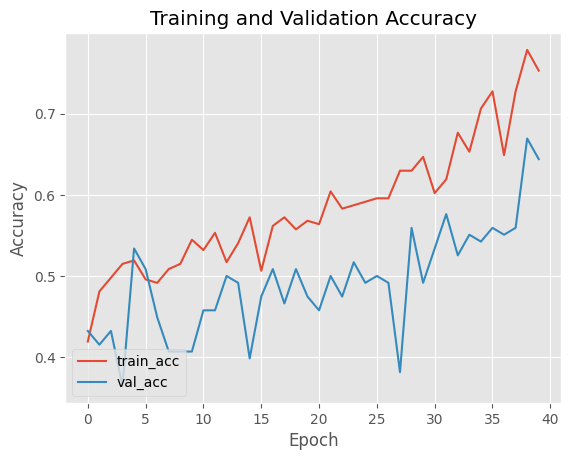

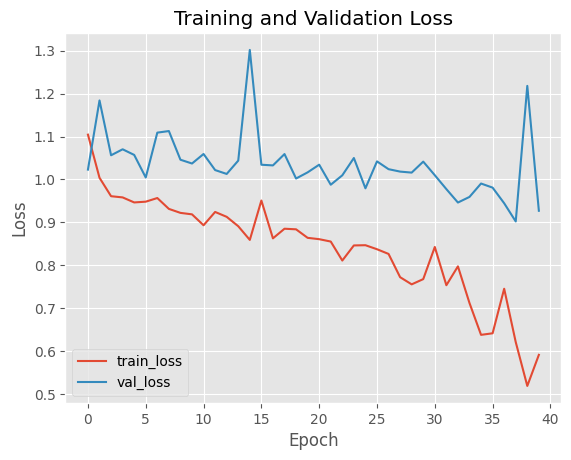

In [25]:
# Lakukan penyimpanan model
print("[INFO] saving survival prediction model...")
model.save(model_path, save_format="h5")  # Save dalam format .h5

# Munculkan hasil klasifikasi dan kompilasi dari pelatihan data
epochs_range = range(EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(epochs_range, H.history["accuracy"], label="train_acc")
plt.plot(epochs_range, H.history["val_accuracy"], label="val_acc")
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.style.use("ggplot")
plt.figure()
plt.plot(epochs_range, H.history["loss"], label="train_loss")
plt.plot(epochs_range, H.history["val_loss"], label="val_loss")
plt.legend(loc="lower left")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()